In [1]:
#package
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using DataFrames
using CSV
using Base.Threads
using HDF5
gr()

Plots.GRBackend()

In [39]:
c = h5open("/Users/nishimura/home/lab/exmc/result/chi/chi5_B40.h5", "r") do file
    read(file, "B40")
end

1000×72 Matrix{Float64}:
  0.0951134  -0.458443    0.469749     …   0.102072    0.116534    0.120638
 -0.447063    0.352441   -0.325435         0.11644     0.119706    0.109116
  0.374732   -0.26587     0.121841         0.120598    0.10831     0.119483
 -0.342784    0.143309   -0.266179         0.105029    0.118966    0.106345
  0.0296282  -0.223528    0.0412414        0.116915    0.109814    0.10498
 -0.0802022   0.0191214  -0.281089     …   0.105228    0.105681    0.110178
  0.0905005  -0.114698    0.337006         0.106545    0.110969    0.105766
 -0.105557    0.32709     0.134094         0.115583    0.104681    0.104127
  0.131351    0.0724588  -0.219119         0.102777    0.101606    0.121452
  0.0878335  -0.149705    0.246455         0.102601    0.124878    0.120814
 -0.269011    0.0897964  -0.148385     …   0.12632     0.118244    0.122812
  0.102184   -0.123009    0.0571314        0.116546    0.124488    0.131785
 -0.0570786   0.0447486  -0.264622         0.126105    0.130713 

In [40]:
ac = h5open("/Users/nishimura/home/lab/exmc/result/chi/chi5_ac_ex.h5", "r") do file
    read(file, "ac")
end

ex = h5open("/Users/nishimura/home/lab/exmc/result/chi/chi5_ac_ex.h5", "r") do file
    read(file, "ex")
end

72-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.93
 0.892
 0.918
 0.889
 0.88
 0.865
 0.86
 0.86
 0.856
 0.835
 0.817
 0.0

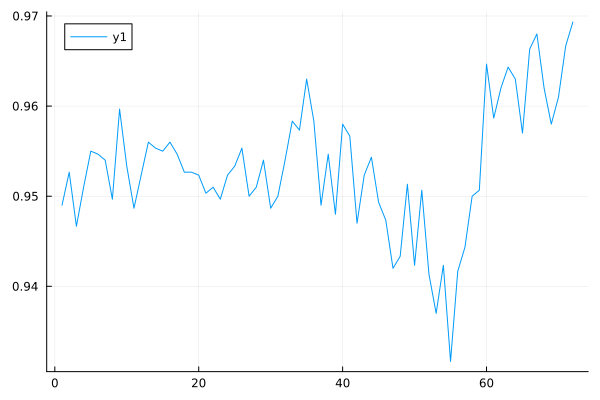

In [41]:
plot(ac)

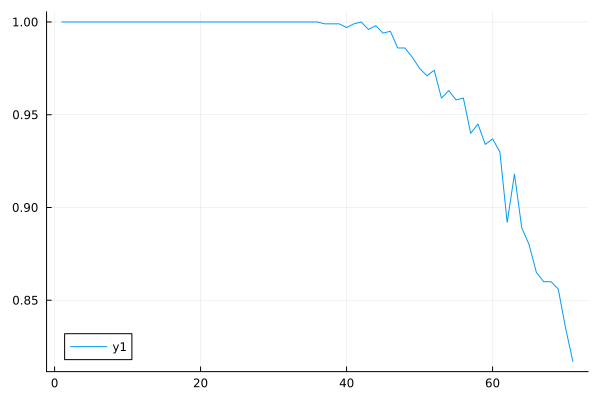

In [42]:
plot(ex[1:end-1])

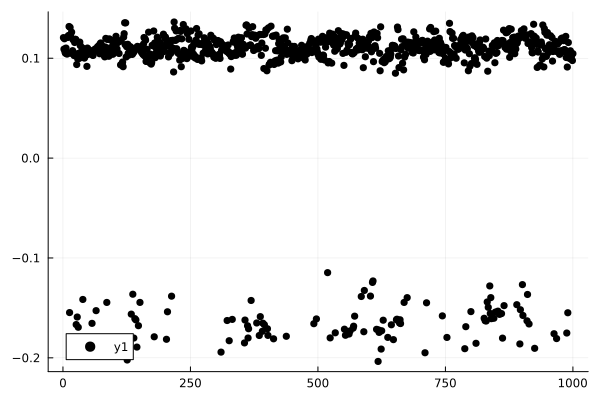

In [43]:
plot(
    c[:,end],
    st = :scatter,
    color = :black,
)

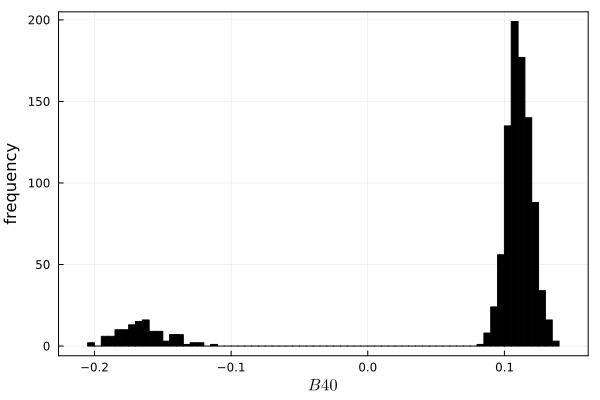

In [44]:
plot(
    c[:,end],
    st = :histogram,
    color = :black,
    label = "",
    framestyle = :box,
    xlabel = L"B40",
    ylabel = "frequency",
)

In [45]:
savefig("/Users/nishimura/home/lab/exmc/posterior/chi/chi5.pdf")

"/Users/nishimura/home/lab/exmc/posterior/chi/chi5.pdf"

In [46]:
# 本データ読み込み
function read_file_chi(file_path)
    file = h5open(file_path, "r")
    data = read(file, "chi_inv")
    return data
end

read_file_chi (generic function with 1 method)

In [47]:
#データ数
function data_num()
    n = 350
    return n
end
n_chi = data_num()

#各種結晶場パラメータ
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

#温度配列
function temp()
    Temp_table = collect(0.2:0.2:70) # length 350
    return Temp_table
end

#結晶場行列
function Onn_make(B40)
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)
    Onn = O40
    # O44
    B44 = 5 * B40
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    return Onn
end


#磁化率生成関数
function chi(Onn)
    # 温度定義
    Temp_table_chi = temp()

    _, g, Jz = ini()
    magfield = 0.01
    #magdir = [0,0,1]
    #nor_magdir = [0,0,1]
    
    # 対角要素
    Hmag_vec_0 = Jz * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag
    
    eigval, eigvec = eigen(H)

    Temp_table_chi = temp()
    chi_inv_Temp = zeros(n_chi)
    
    @inbounds for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        @simd for j in 1:6
            eigvec_check = eigvec[:,j]
            mag_z[j] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[j] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1.0 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end


#誤差関数
function error_chi(B40, chi_inv_Temp_noise)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n_chi)
    return error_value
end

function error_chi_list(para_list, chi_inv_Temp_noise)
    error_list = zeros(size(para_list)[1],size(para_list)[2])
    @threads for i in 1:size(para_list)[1]
        for j in 1:size(para_list)[2]
            error_list[i,j] = error_chi(para_list[i,j], chi_inv_Temp_noise)
        end
    end
    return error_list
end



error_chi_list (generic function with 1 method)

In [48]:
function make_beta(gamma,L)
    #最初は等差で決定
    beta_list = gamma.^( (2:1:L) .- (L) )
    beta_list = pushfirst!(beta_list, 0.0)
    return beta_list
end

make_beta (generic function with 1 method)

In [49]:
function find_free_energy_chi(error_chi, b_chi, gamma, L)
    # 温度リスト
    beta = make_beta(gamma, L)
    #温度差
    beta_dif = beta[2:end] - beta[1:end-1]
    
    #温度差をかける
    for replica in 1:L-1
        error_chi[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_chi *= - n_chi * b_chi
    error = error_chi

    #最大値取得
    error_max = zeros(L-1)
    for replica in 1:L-1
        error_max[replica] = maximum(error[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_dif = copy(error)
    for replica in 1:L-1
        error_dif[:,replica] = error[:,replica] .- error_max[replica]
    end
    
    #期待値計算
    log_exp_sum = zeros(L-1)
    for replica in 1:L-1
        log_exp_sum[replica] = log(sum(exp.(error_dif)[:,replica]))
    end
    
    #各レプリカでの自由エネルギー期待値
    free_energy_for_replica = -(- log(size(error)[1]) .+  error_max .+ log_exp_sum)
    
    #最終的な自由エネルギー(足し算)
    free_energy = sum(free_energy_for_replica) - n_chi/2*(log(b_chi)-log(2*pi))
    
    return free_energy
end

find_free_energy_chi (generic function with 1 method)

In [50]:
function main(para, data_path_chi, save_path)

    chi_inv_Temp_noise = read_file_chi(data_path_chi)
    b_chi = 10^(-2)
    error_list_chi = error_chi_list(para, chi_inv_Temp_noise)

    #レプリカ数
    L = 72
    #逆温度間隔決定
    gamma = 1.4
    # 自由エネルギー
    free_energy = find_free_energy_chi(error_list_chi, b_chi, gamma, L)
    

    # データフレームに書き出し
    #df_error = DataFrame(error_list, :auto)
    #df_error |> CSV.write(save_path * "error.csv",writeheader=true)

    #free_path = save_path * "free.h5"
    #=
    h5open(free_path, "w") do file
        write(file,"free",free_energy)
    end
    =#

    print("free_energy=", free_energy)
end

main (generic function with 1 method)

In [51]:
data_path_chi = "/Users/nishimura/home/lab/data_make/data/chi_inv/chi_inv_5.h5"

save_path = ""

main(c, data_path_chi, save_path)

free_energy=1304.133978674898